## Find the potentially positionless position subsets

Since the full five positions aren't actually positionless, let's check what happens when we run a classifier specifically for the potentially positionless subset

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, entropy
from itertools import combinations

from UtilFunctions import format_season


In [84]:
def pre_process(seasons):
    df = None
    for season in seasons:
        per_min_cols = ['FGA', '3PA', '2PA', 'PF', 'PTS', 'OWS', 'DWS', 'OBPM', 'DBPM', 'BPM']
        cols_to_drop = None
        first_year, second_year = format_season(season)
        player_data = pd.read_csv(f"DataCollection/Player_Stats/player_stats_{first_year}-{second_year}.csv")
        if all(True if s > 1997 else False for s in seasons) or (len(seasons) == 1 and season > 1998):
            cols_to_drop = ['index', 'TRB', 'DRB', 'ORB', 'AST', 'G', 'GS', '2PAr', 'FT', 'FG', 'FG%', 'BLK', 'STL', 'Dunks', 
                                  'Heaves', 'HeavesAttempted', 'WS', 'FTA', 'TOV', 'Age', '2P', '3P', 'VORP']
            shooting_data = pd.read_csv(f"DataCollection/Player_Shooting_Stats/Regular_Season/player_shooting_stats_{first_year}-{second_year}.csv")
            player_data = pd.merge(player_data, shooting_data.loc[:,~shooting_data.columns.isin(['Pos', 'Age', 'G', 'MP', 'FG%', "3PAr", "2P%", "3P%"])], on=['Player', 'Tm'])

        else:
            cols_to_drop = ['index', 'TRB', 'DRB', 'ORB', 'AST', 'G', 'GS', 'FT', 'FG', 'FG%', 'BLK', 'STL',
                                'WS', 'FTA', 'TOV', 'Age', '2P', '3P', 'VORP']
            
        player_data = player_data.fillna(0)
        player_data = player_data[(player_data["MP"] > 15) & (player_data["G"] >= 30)]
        player_data = player_data.sort_values(by=['G'], ascending=False)
        player_data = player_data[player_data["Tm"] != "TOT"]
        player_data = player_data.drop_duplicates(subset ="Player",keep = "first")
        player_data.reset_index(inplace=True)
        player_data.drop(columns=cols_to_drop, inplace=True)
        
        for col in per_min_cols:
            player_data[col] = player_data[col] / player_data['MP'] * 36
        
        if df is None:
            df = player_data
        else:
            df = pd.concat([df, player_data])
            
    df.reset_index(inplace=True)
    df.drop(['index', 'Player', 'Tm'], axis=1, inplace=True)
    return df

In [85]:
def random_forest_classify(X_train, y_train):
    rf = RandomForestClassifier()
    rand_search = RandomizedSearchCV(rf, param_distributions = {'n_estimators': randint(50,500), 'max_depth': randint(1, 30)},
                                 n_iter = 10, cv = 5, random_state=42)
    rand_search.fit(X_train, y_train)
    return rand_search.best_estimator_

In [86]:
def train_test_split(seasons, positions):
    train_df = pre_process(seasons[:-1])
    test_df = pre_process(seasons[-1:])
    
    train_df = train_df[train_df['Pos'].isin(positions)]
    test_df = test_df[test_df['Pos'].isin(positions)]
    
    return train_df.loc[:, ~train_df.columns.isin(['Pos'])], test_df.loc[:, ~test_df.columns.isin(['Pos'])], train_df['Pos'], test_df['Pos']

In [87]:
def calculate_probability_matrix(cm):
    prob_matrix = []
    for i in range(len(cm)):
        prob_matrix.append([])
        players_in_position = sum(cm[i,:])
        for j in range(len(cm)):
            prob_matrix[i].append(round(cm[i,j]/players_in_position, 2))
    
    return prob_matrix

In [ ]:
def entropy_by_position(positions, p_matrix):
    entropies = {}
    i = 0
    for position in positions:
        entropies[position] = entropy(p_matrix[i], base=2)
        i += 1
    return entropies

In [89]:
def classify_year_by_year(seasons, training_seasons=4, positions=["PG", "SG", "SF", "PF", "C"]):
    entropies_df = pd.DataFrame()
    confusion_matrices = {}
    for season in seasons:
        X_train, X_test, y_train, y_test = train_test_split(range(season,season+training_seasons+1), positions)
        rf = random_forest_classify(X_train, y_train)
        y_pred = rf.predict(X_test)

        cm = confusion_matrix(y_test, y_pred, labels=positions)
        prob_matrix = calculate_probability_matrix(cm)
        entropies_df[season+training_seasons] = entropy_by_position(positions, prob_matrix)
        confusion_matrices[season+training_seasons] = cm

    entropies_df = entropies_df.T
    return entropies_df, confusion_matrices

In [90]:
def find_positionless_potential_subsets(final_matrix, size, minimum_threshold):
    labels = ["PG", "SG", "SF", "PF", "C"]
    n = len(final_matrix)
    positionless_subsets = set()

    # Generate all combinations of indices
    indices = list(range(n))
    for comb in combinations(indices, size):
        submatrix = final_matrix[np.ix_(comb, comb)]
        if np.all(submatrix > minimum_threshold):
            positions = [labels[i] for i in comb]
            if len(positions) == len(set(positions)):
                positions = sorted(positions)
                positionless_subsets.add(tuple(positions))
    
    return list(positionless_subsets)

In [91]:
def random_hypothesis(seasons, positions):
    entropies_df = {season: [] for season in seasons}
        
    for i in range(1000):
        if i % 100 == 0:
            print(f"Iteration {i}")
        for season in seasons:
            df = pre_process([season], 0)
            df = df[df['Pos'].isin(positions)]
            
            y_test = df['Pos']
            y_pred = [positions[randint.rvs(0, len(positions))] for _ in range(len(df.index))]

            cm = confusion_matrix(y_test, y_pred, labels=positions)
            prob_matrix = calculate_probability_matrix(cm)
            
            entropies_df[season].append(entropy_by_position(positions, prob_matrix))

    return entropies_df

In [92]:
def get_positionless_borderlines(entropies, positions):
    positionless_borderlines = {}
    for season in entropies.keys():
        positionless_borderlines[season] = {}
        
        for position in positions:            
            entropies_each_season = [e[position] for e in entropies[season]]
            positionless_borderlines[season][position] = (np.percentile(entropies_each_season, 99),
                                                           np.percentile(entropies_each_season, 1))
    
    return positionless_borderlines

### First, let's run the standard classifier

This is necessary to find the distribution matrix and define what are the subsets that must be considered as potentially positionless

In [93]:
entropies_df, confusion_matrices = classify_year_by_year(range(1980, 2021), 4)

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- 0-3%
- 0-3Ar
- 10-16%
- 10-16Ar
- 16-3P%
- ...


### Second, we get the distribution matrix

Change the confusion matrix to a distribution matrix, based on the true position of the player (each cell has the percentage of its row it represents, not of the matrix's total)

distribution_matrices = []

for season, matrix in confusion_matrices.items():
    row_sums = matrix.sum(axis=1, keepdims=True)
    distribution_matrix = matrix / row_sums
    distribution_matrices.append(distribution_matrix)

In [ ]:
distribution_matrices = []

for season, matrix in confusion_matrices.items():
    row_sums = matrix.sum(axis=1, keepdims=True)
    distribution_matrix = matrix / row_sums
    distribution_matrices.append(distribution_matrix)

### Get the maximum value for each cell over the seasons
This will create a matrix that will be used to define what subsets should actually be considered

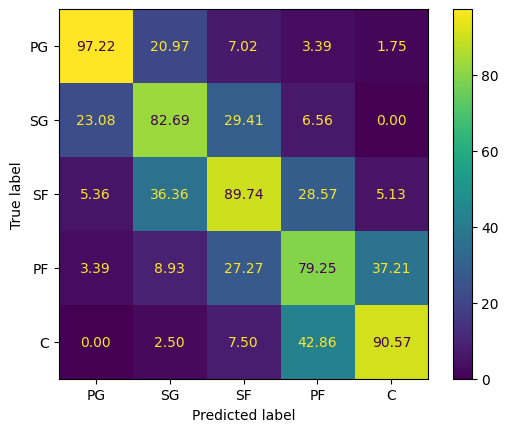

In [ ]:
final_matrix = np.zeros_like(distribution_matrices[0])

# Accumulate the matrices by taking the maximum value for each cell
for distribution_matrix in distribution_matrices:
    final_matrix = np.maximum(final_matrix, distribution_matrix)

final_matrix = final_matrix * 100

ConfusionMatrixDisplay(final_matrix, display_labels=["PG", "SG", "SF", "PF", "C"]).plot(values_format=".2f") 

### Find the subsets that have positionless potential

In [ ]:
positionless_groups = []

for size in range(2, 6):
    positionless_groups.extend(find_positionless_potential_subsets(final_matrix, size, 5.0))

### Find the threshold for positionless for each subset in each season

In [ ]:
seasons = range(1984, 2025)

positionless_markers = {pg: {season: False for season in seasons} for pg in positionless_groups}
group_entropies = {pg: [] for pg in positionless_groups}
positionless_borderlines_per_group = {pg: [] for pg in positionless_groups}


for pg in positionless_groups:
    print(pg)
    pg_list = list(pg)
    
    predicted_entropies, _ = classify_year_by_year(range(1980, 2021), 4, pg_list)
    entropies = random_hypothesis(range(1984, 2025), pg_list)

    positionless_borderlines = get_positionless_borderlines(entropies, pg_list)    
    positionless_borderlines_per_group[pg] = positionless_borderlines
    
    for season, row in predicted_entropies.iterrows():
        cumulative_entropy_prediction = sum([row[pos] for pos in pg_list])
        group_entropies[pg].append(cumulative_entropy_prediction)
        cumulative_entropy_null_model = sum([positionless_borderlines[season][pos] for pos in pg_list])
        
        if cumulative_entropy_prediction > cumulative_entropy_null_model:
            positionless_markers[pg][season] = True

    

('C', 'SF')
Iteration 0
Iteration 100
Iteration 200
Iteration 300
Iteration 400
Iteration 500
Iteration 600
Iteration 700
Iteration 800
Iteration 900
('PF', 'SF')
Iteration 0
Iteration 100
Iteration 200
Iteration 300
Iteration 400
Iteration 500
Iteration 600
Iteration 700
Iteration 800
Iteration 900
('PG', 'SF')
Iteration 0
Iteration 100
Iteration 200
Iteration 300
Iteration 400
Iteration 500
Iteration 600
Iteration 700
Iteration 800
Iteration 900
('PF', 'SG')
Iteration 0
Iteration 100
Iteration 200
Iteration 300
Iteration 400
Iteration 500
Iteration 600
Iteration 700
Iteration 800
Iteration 900
('PG', 'SG')
Iteration 0
Iteration 100
Iteration 200
Iteration 300
Iteration 400
Iteration 500
Iteration 600
Iteration 700
Iteration 800
Iteration 900
('SF', 'SG')
Iteration 0
Iteration 100
Iteration 200
Iteration 300
Iteration 400
Iteration 500
Iteration 600
Iteration 700
Iteration 800
Iteration 900
('C', 'PF')
Iteration 0
Iteration 100
Iteration 200
Iteration 300
Iteration 400
Iteration 500
I

In [17]:
import itertools

In [18]:
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

In [19]:
from scipy.signal import savgol_filter

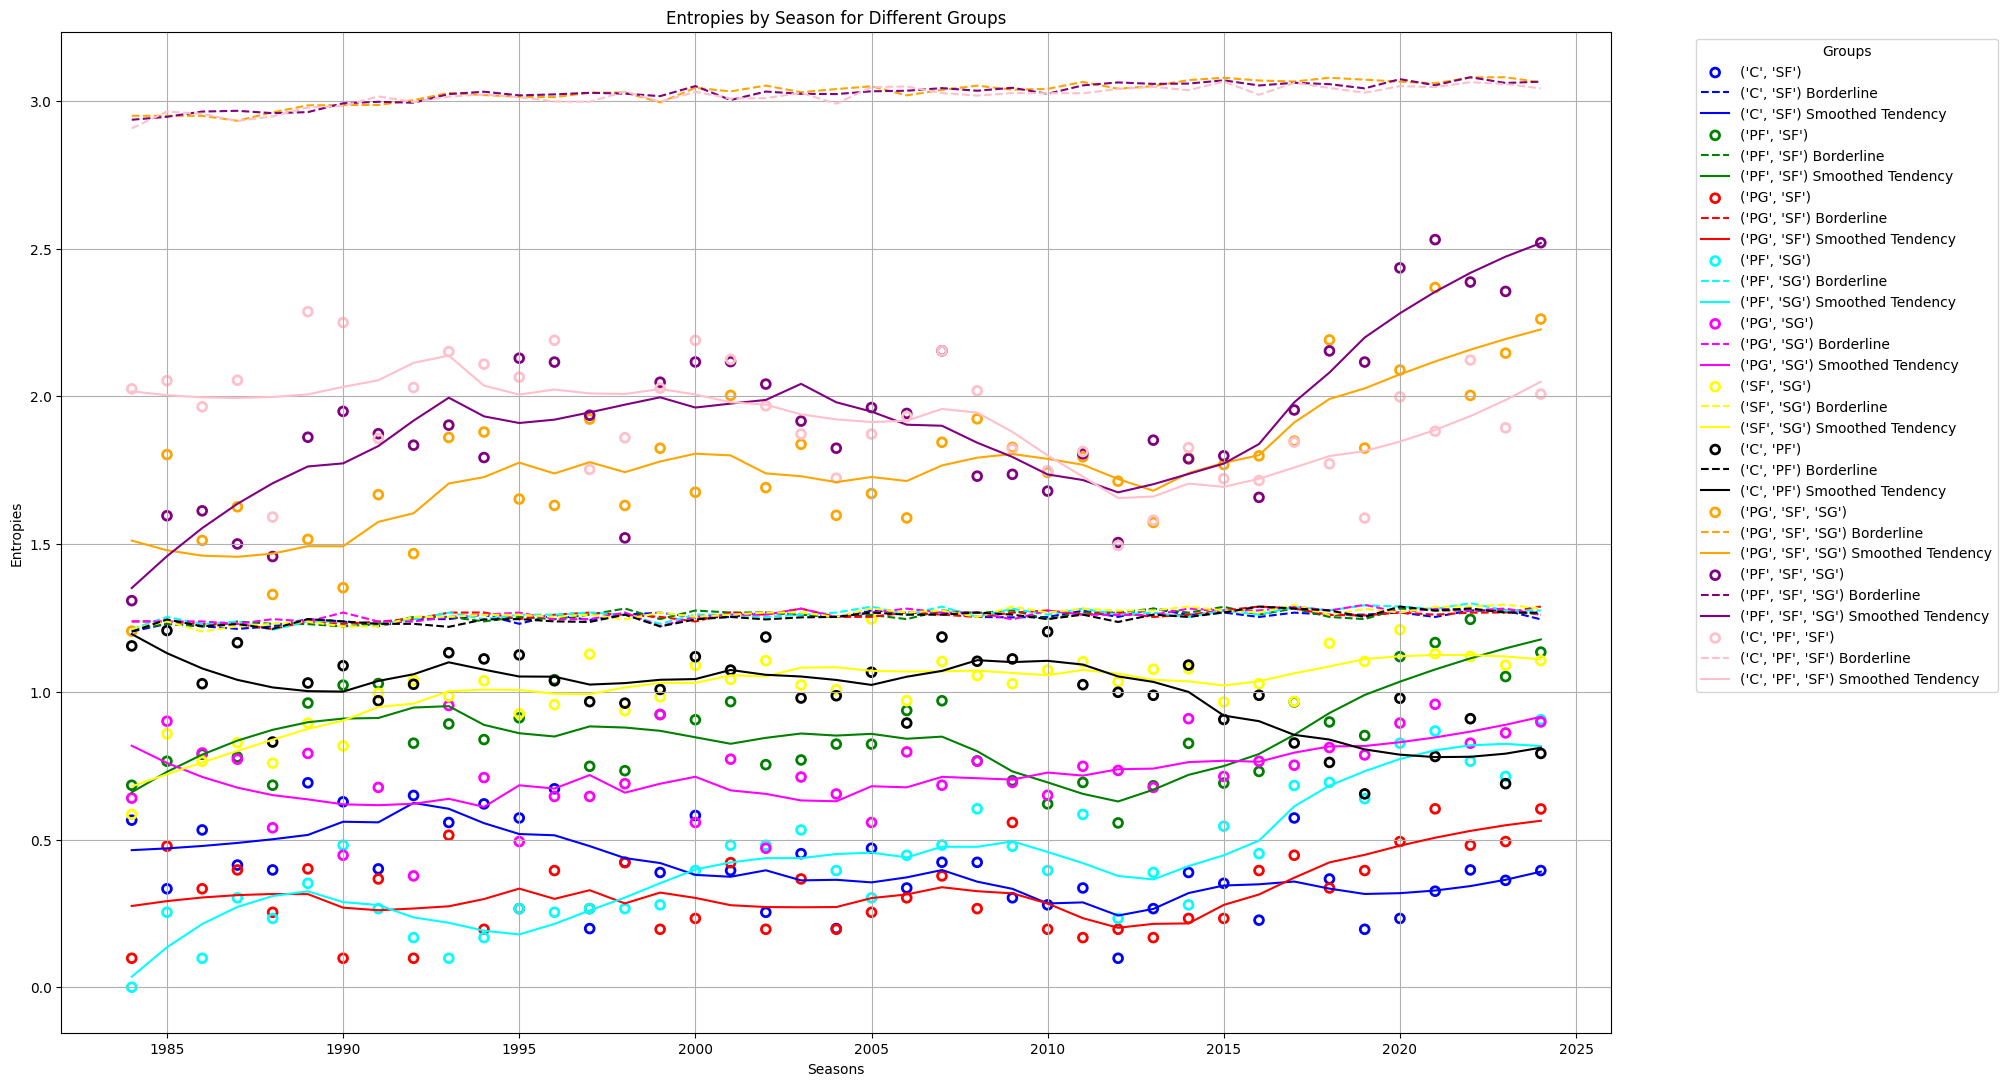

In [20]:
colors = itertools.cycle(['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'orange', 'purple', 'pink', 'brown', 'lime', 'navy', 'teal'])

# Create the scatter plot
plt.figure(figsize=(20, 13))

for pg, color in zip(positionless_groups, colors):
    ge = group_entropies[pg]
    for season, e in zip(seasons, ge):
        fill_style = 'full' if positionless_markers[pg][season] else 'none'
        plt.scatter(season, e, edgecolor=color, facecolor=color if fill_style == 'full' else 'none', marker='o', s=40, lw=2, label=pg if season == seasons[0] else "")
    
    # Add line charts for positionless_borderlines_per_group
    borderlines = [sum(list(positionless_borderlines_per_group[pg][season].values())) for season in seasons]
    plt.plot(seasons, borderlines, label=f'{pg} Borderline', color=color, linestyle='--')
    
    # Add smoothed tendency lines using Savitzky-Golay filter
    smoothed_entropies = savgol_filter(ge, window_length=11, polyorder=2)
    plt.plot(seasons, smoothed_entropies, label=f'{pg} Smoothed Tendency', color=color, linestyle='-')

# Customize the plot
plt.xlabel('Seasons')
plt.ylabel('Entropies')
plt.title('Entropies by Season for Different Groups')
plt.legend(title='Groups', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()